In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [12]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [13]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


# 0.0 Creación de features de interes


Calculo de la distancia de manhattan

In [15]:
import numpy as np

# Radio de la Tierra en kilómetros
R = 6371  

# convertimos a radianes
df['pickup_latitude_rad'] = np.radians(df['pickup_latitude'])
df['pickup_longitude_rad'] = np.radians(df['pickup_longitude'])
df['dropoff_latitude_rad'] = np.radians(df['dropoff_latitude'])
df['dropoff_longitude_rad'] = np.radians(df['dropoff_longitude'])

# Realizamos la diferencia entre los radianes
delta_lat = df['dropoff_latitude_rad'] - df['pickup_latitude_rad']
delta_lon = df['dropoff_longitude_rad'] - df['pickup_longitude_rad']

# fórmula de Haversine
df['d_haversine'] = 2 * R * np.arcsin(np.sqrt(
    np.sin(delta_lat  / 2) ** 2 +
    np.cos(df['pickup_latitude_rad']) * np.cos(df['dropoff_latitude_rad']) *
    np.sin(delta_lon / 2) ** 2
))

df['d_haversine'].head(3)

0    1.683323
1    2.457590
2    5.036377
Name: d_haversine, dtype: float64

Mes - día - hora

In [16]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['month'] = df['pickup_datetime'].dt.month
df['days_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour 

GRAFICAS

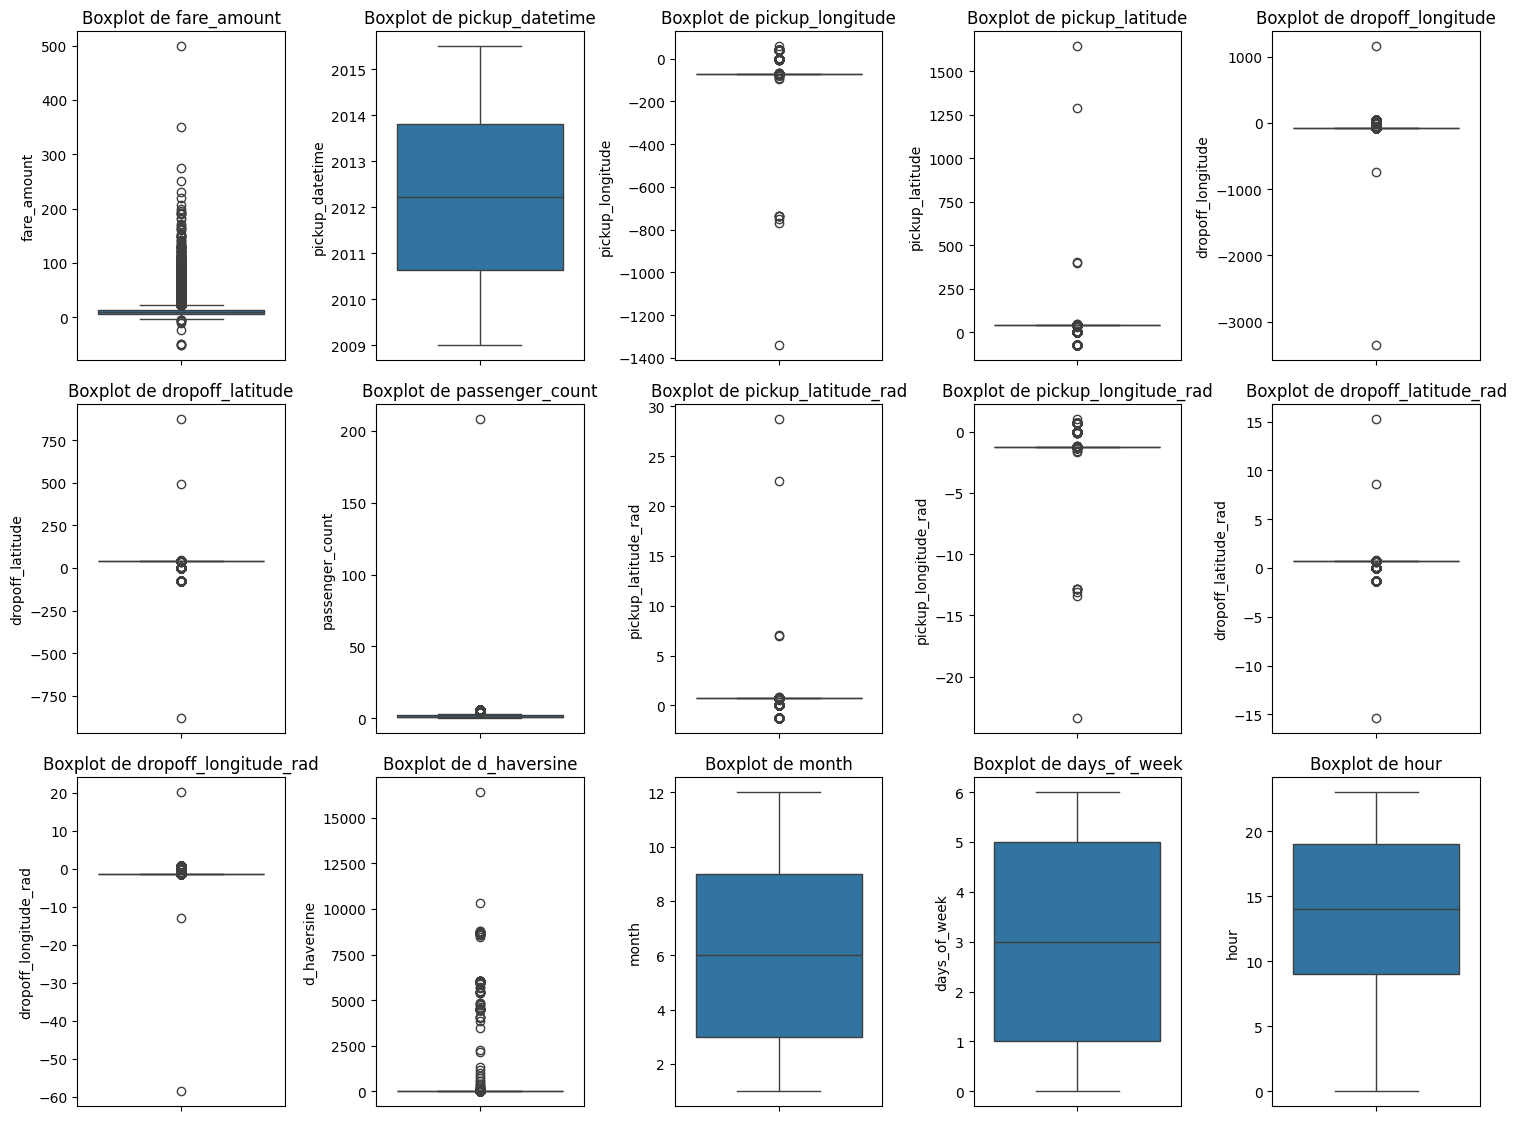

In [17]:

plt.figure(figsize=(15,15))
columnas = df.drop(columns=['key','date']).columns
for column in range(len(columnas)):
    plt.subplot(4, 5, column + 1)
    sns.boxplot(y=df[columnas[column]])
    plt.title(f'Boxplot de {columnas[column]}')
plt.tight_layout()
plt.show()

In [24]:
sns.heatmap(df.drop(columns=['key','date']))

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [18]:
# Filtrar valores positivos de fare_amount
df = df[df['fare_amount'] > 0]

# Calcular cuantiles (percentil 99)
q99_haversine = df['d_haversine'].quantile(0.99)
q99_fare = df['fare_amount'].quantile(0.99)

# Calcular la mediana de cada columna
median_haversine = df['d_haversine'].median()
median_fare = df['fare_amount'].median()

# Reemplazar valores atípicos por la mediana
df.loc[df['d_haversine'] > q99_haversine, 'd_haversine'] = median_haversine
df.loc[df['fare_amount'] > q99_fare, 'fare_amount'] = median_fare



# 1. Análisis exploratorio de los Datos (EDA)

## 1.1 Análisis de los datos faltantes

In [19]:
print("Análisis de datos faltantes:")

missing_data = pd.DataFrame({
    'Valores faltantes' : df.isnull().sum(),
    'Porcentaje' : (df.isnull().sum() / len(df)) * 100})
print(missing_data)

Análisis de datos faltantes:
                       Valores faltantes  Porcentaje
key                                    0      0.0000
date                                   0      0.0000
fare_amount                            0      0.0000
pickup_datetime                        0      0.0000
pickup_longitude                       0      0.0000
pickup_latitude                        0      0.0000
dropoff_longitude                      1      0.0005
dropoff_latitude                       1      0.0005
passenger_count                        0      0.0000
pickup_latitude_rad                    0      0.0000
pickup_longitude_rad                   0      0.0000
dropoff_latitude_rad                   1      0.0005
dropoff_longitude_rad                  1      0.0005
d_haversine                            1      0.0005
month                                  0      0.0000
days_of_week                           0      0.0000
hour                                   0      0.0000


## 1.2 Visualización de distribuciones y detección de valores atípicos

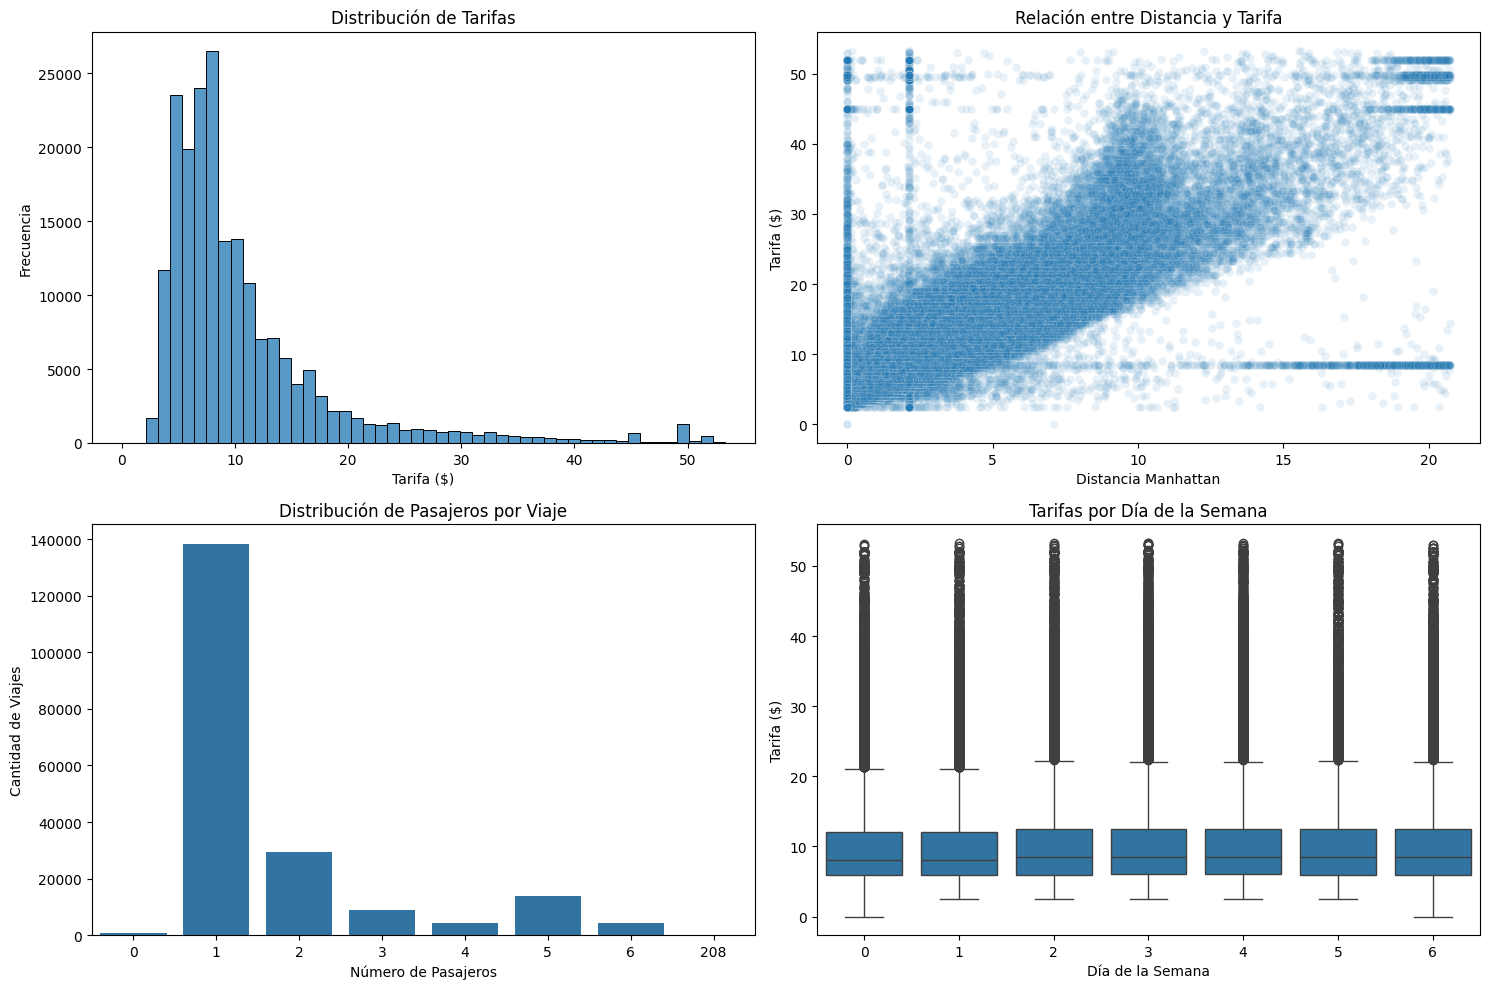

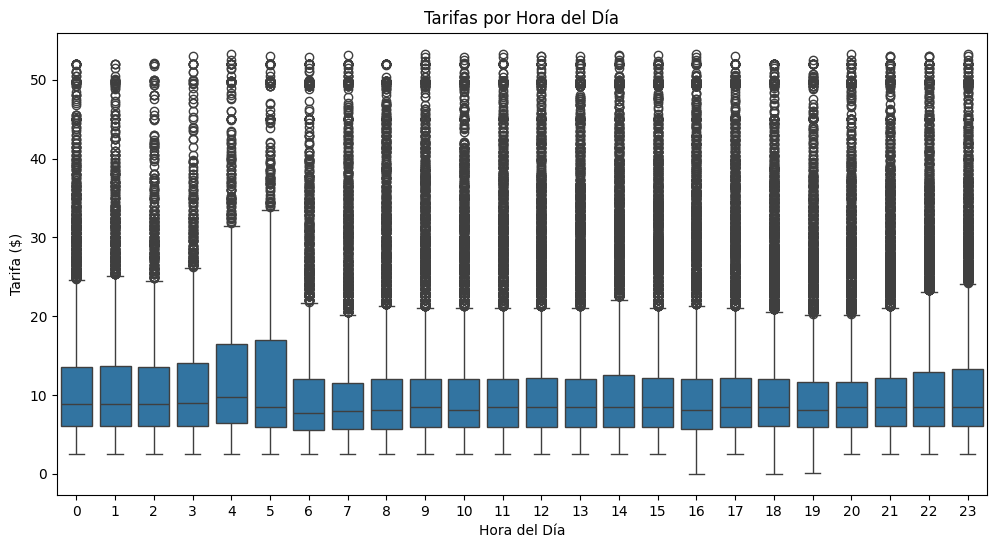

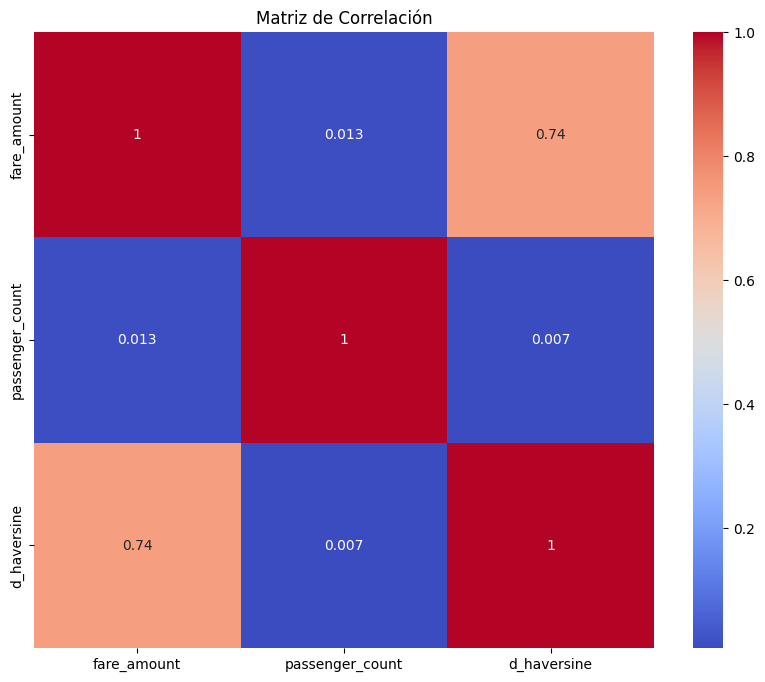

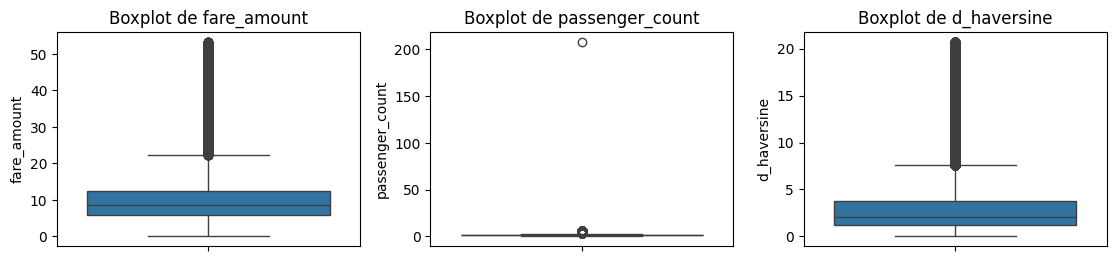

In [20]:
# Configuración del estilo
#plt.style.use('seaborn')

# 1. Panel de visualizaciones principales
fig = plt.figure(figsize=(15, 10))

# Distribución de tarifas
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='fare_amount', bins=50)
plt.title('Distribución de Tarifas')
plt.xlabel('Tarifa ($)')
plt.ylabel('Frecuencia')

# Relación entre distancia y tarifa
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='d_haversine', y='fare_amount', alpha=0.1)
plt.title('Relación entre Distancia y Tarifa')
plt.xlabel('Distancia Manhattan')
plt.ylabel('Tarifa ($)')

# Distribución de pasajeros
plt.subplot(2, 2, 3)
sns.countplot(data=df, x='passenger_count')
plt.title('Distribución de Pasajeros por Viaje')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Cantidad de Viajes')

# Tarifas por día de la semana
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='days_of_week', y='fare_amount')
plt.title('Tarifas por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Tarifa ($)')

plt.tight_layout()
plt.show()

# 2. Análisis temporal
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='hour', y='fare_amount')
plt.title('Tarifas por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Tarifa ($)')
plt.show()

# 3. Matriz de correlación
numeric_columns = ['fare_amount',                                                     
'passenger_count',                
'd_haversine']
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# 4. Análisis de valores atípicos
plt.figure(figsize=(15, 5))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot de {column}')
plt.tight_layout()
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [22]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_rad,pickup_longitude_rad,dropoff_latitude_rad,dropoff_longitude_rad,d_haversine,month,days_of_week,hour
count,1.599820e+05,159982.000000,159982.000000,159981.000000,159981.000000,159982.000000,159982.000000,159982.000000,159981.000000,159981.000000,159981.000000,159982.000000,159982.000000,159982.000000
mean,2.771668e+07,-72.507718,39.926873,-72.505261,39.917405,1.683708,0.696855,-1.265498,0.696690,-1.265456,3.100692,6.282182,3.047287,13.484661
std,1.602138e+07,10.879885,7.013139,10.990453,6.641630,1.404167,0.122402,0.189890,0.115918,0.191820,3.168812,3.438106,1.946412,6.517412
min,1.000000e+00,-768.550000,-74.015515,-737.916665,-881.985513,0.000000,-1.291814,-13.413728,-15.393551,-12.879075,0.000000,1.000000,0.000000,0.000000
25%,1.381372e+07,-73.992081,40.734765,-73.991428,40.733738,1.000000,0.710956,-1.291405,0.710938,-1.291394,1.215940,3.000000,1.000000,9.000000
50%,2.777412e+07,-73.981832,40.752566,-73.980118,40.753010,1.000000,0.711266,-1.291227,0.711274,-1.291197,2.121109,6.000000,3.000000,14.000000
75%,4.155797e+07,-73.967207,40.767182,-73.963623,40.768035,2.000000,0.711522,-1.290971,0.711536,-1.290909,3.761197,9.000000,5.000000,19.000000
max,5.542357e+07,57.418457,1292.016128,1153.572603,493.533332,208.000000,22.549935,1.002141,8.613782,20.133640,20.719563,12.000000,6.000000,23.000000


### Valores atípicos? Análisis sobre los datos de entrenamiento


In [23]:
X_train.head(5)

,key,date,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_rad,pickup_longitude_rad,dropoff_latitude_rad,dropoff_longitude_rad,d_haversine,month,days_of_week,hour
183960,34622716,2014-02-13 19:08:37.0000001,2014-02-13 19:08:37+00:00,-73.970451,40.758081,-73.994107,40.722790,1,0.711363,-1.291028,0.710747,-1.291441,4.401280,2,3,19
15044,12750110,2011-12-24 11:56:15.0000006,2011-12-24 11:56:15+00:00,-73.994524,40.726179,-73.982727,40.777250,1,0.710806,-1.291448,0.711697,-1.291242,5.765125,12,5,11
11425,29533645,2013-08-19 21:20:11.0000001,2013-08-19 21:20:11+00:00,-74.012794,40.706418,-74.005794,40.740149,1,0.710461,-1.291767,0.711050,-1.291645,3.796821,8,0,21
138866,30443761,2013-03-21 20:51:00.000000222,2013-03-21 20:51:00+00:00,-73.974745,40.750205,-73.981267,40.762047,4,0.711225,-1.291103,0.711432,-1.291217,1.426767,3,3,20
74154,40448355,2012-03-23 10:29:00.000000121,2012-03-23 10:29:00+00:00,-73.985697,40.688193,-73.992162,40.684792,1,0.710143,-1.291294,0.710084,-1.291407,0.663450,3,4,10


Para mejorar la predicción del costo del viaje, calcularemos la distancia recorrida en cada viaje utilizando la distancia de Manhattan, que es útil cuando las calles tienen forma de cuadrícula. Desconocemos las formas de las cuadras pero vamos a tomarlo como un estandar en este caso.

La distancia de Manhattan entre dos puntos \( P(x_1, y_1) \) y \( Q(x_2, y_2) \) en dos dimensiones se calcula como:

$$
d = |x_1 - x_2| + |y_1 - y_2|
$$

En un espacio \( n \)-dimensional, se generaliza como:

$$
d = \sum_{i=1}^{n} |x_i - y_i|
$$
